In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from package.Data import TemporalData, Audio, Dataset
from package.Kernels import DWT
import numpy as np
import pandas as pd

# Loading Data 

In [3]:
# Defining Speaker information Based on speaker code (found in each filename)
speakers = { 
    '03' : ('male', 31),
    '08' : ('female', 34),
    '09' : ('female', 21),
    '10' : ('male', 32),
    '11' : ('male', 26),
    '12' : ('male', 30),
    '13' : ('female', 32),
    '14' : ('female', 35),
    '15' : ('male', 25),
    '16' : ('female', 31)
}

#Defining label and Emotion string from emotion code (found in each filename)
emotions = {
    'W' : 'anger',
    'L' : 'boredom',
    'E' : 'disgust',
    'A' : 'anxiety/fear',
    'F' : 'happiness',
    'T' : 'sadness',
    'N' : 'neutral',
}
audios = []
classes = []
for filename in os.listdir('Berlin Database Of Emotional Speech'):
    # Reading Data from .wav Files
    if filename.endswith('.wav'):
        windowedAudios, n_windows = Audio('Berlin Database Of Emotional Speech/'+filename).window(2**14, overlap = 0.6)
        audios += windowedAudios
        classes += [{
            'speaker': filename[:2],
            'sex': speakers[filename[:2]][0],
            'age': speakers[filename[:2]][1],
            'text code': filename[2:5] ,
            'emotion': emotions[filename[5]],
        }]* n_windows

X = pd.DataFrame(audios)
classes = pd.DataFrame(classes)
label = classes['emotion']

dataset = Dataset(X, y= label, classes = classes)

/Users/agustinrestrepo/Documents/Projects/EmotionSystem/package/Data.py:33: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read(filename)


# Preprocessing Data

In [4]:
dwt = DWT()
datasetdwt = dwt.fit(dataset)

100%|██████████| 1786/1786 [03:33<00:00,  8.37it/s]


In [4]:
dataset = Dataset.load(name='datasetdwt')

In [5]:
from package.Kernels import Normalize, Dropna
norm = Normalize()
dataset = norm.fit(dataset)
dropna = Dropna()
dataset = dropna.fit(dataset)

# Feature Selection 

In [6]:
%matplotlib qt
from package.FeatureSelection import ForwardFeatureSelection
ffs = ForwardFeatureSelection()
dataset = ffs.fit(dataset)
dataset.save('.datasetSelection/')
%matplotlib inline

Early stopping, iteration 14, loss did not improve for 5 iterations.


In [3]:
dataset = Dataset.load('.datasetSelection/')

# Space Visualization

In [8]:
from package.Visualization import Visualization3D, Visualization
from umap import UMAP
vis = Visualization3D(reducer = UMAP(n_neighbors=20, min_dist=0.5, n_components=3))
vis.plot(dataset, dataset.classes['emotion'])

<IPython.core.display.Javascript object>

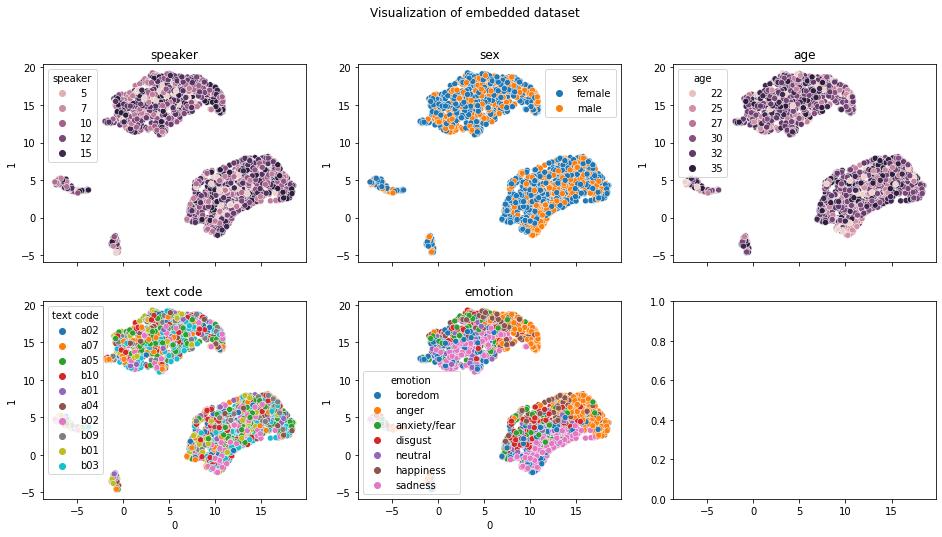

In [12]:
vis = Visualization(reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.5))
# baby plot
vis.plot(dataset)

# Clustering 

 20%|██        | 1/5 [00:00<00:00,  8.60it/s]/opt/anaconda3/envs/ser/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


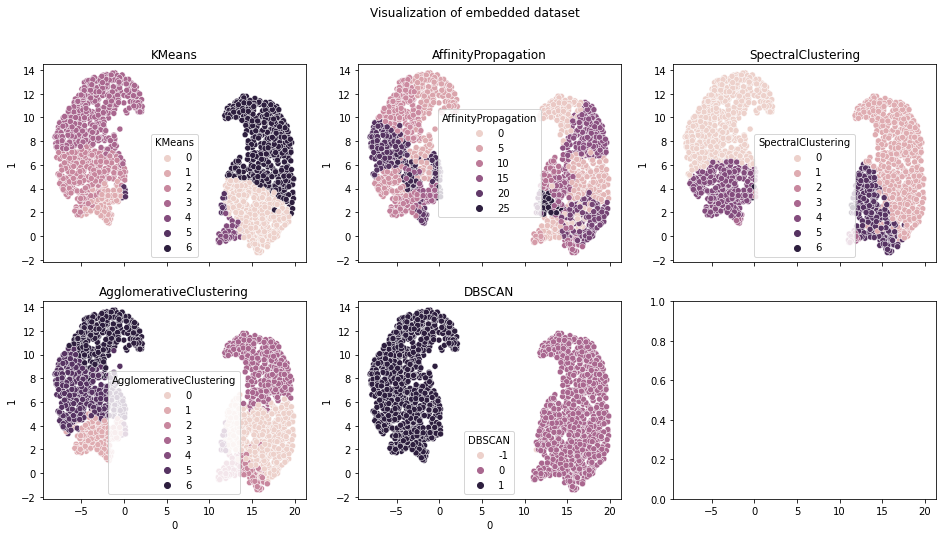

In [19]:
from package.Clustering import Cluster

from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

cluster = Cluster([
        KMeans(7), 
        AffinityPropagation(damping=0.5),  # Damping 0.5-1
        SpectralClustering(n_clusters=7), 
        AgglomerativeClustering(n_clusters=7),
        DBSCAN(eps=0.5)
    ])

clusterDataset = cluster.fit(dataset)
vis.plot(clusterDataset)

# Hyperparameter tuning for supervised learning 

In [5]:
from package.HyperparameterOptimization import HyperparameterOptimization
# import desicion tree
from sklearn.tree import DecisionTreeClassifier
# import BayesSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

optimization = HyperparameterOptimization(
    DecisionTreeClassifier(), 
    [
        Integer(1,100, name='max_depth'),
        Real(0,1e-2, name='min_samples_split'),
        Integer(1,100, name='min_samples_leaf'),
        Real(0,1e-2, name='min_weight_fraction_leaf'),
        Integer(2,200, name='max_leaf_nodes'),
        Real(0,1e-3, name='min_impurity_decrease'),
    ],
    BayesSearchCV())

TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'search_spaces'

In [15]:
dataset


            Dataset
            X: (1786, 14)
            y: (1786, 1)
            classes: (1786, 5)
        

In [27]:
2**9

512

In [28]:
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = dataset.split()

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'max_depth': (1e-6, 1e+2, 'log-uniform'),
        'min_samples_split': (1e-8, 1e-2, 'log-uniform'),
        'min_samples_leaf': (1, 100), # Integer
        'min_weight_fraction_leaf': (1e-8, 1e-2, 'log-uniform'),
        'max_leaf_nodes': (2, 100), # Integer
        'min_impurity_decrease': (1e-8, 1e-2, 'log-uniform'),
    },
    n_iter=2**8,
    cv=3
)

opt.fit(X_train, y_train, n_jobs=4)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))